In [592]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

In [1]:
with open('data/input_15.txt') as fh:
    file_input = fh.read().strip()

In [502]:
def neigbors(x, y):
    yield (x, y - 1)
    yield (x - 1, y)
    yield (x + 1, y)
    yield (x, y + 1)
    
def get_target(unit, units, field):
    possible_targets = []
    min_hp = np.inf
    for nbx, nby in unit.get_adjacent():
        if field[nbx, nby] > 1:
            targets = [u for u in units if u.x == nbx and u.y == nby and u.team != unit.team and u.hp > 0]
            if targets:
                possible_targets.append(targets[0])
                if targets[0].hp < min_hp:
                    min_hp = targets[0].hp
    possible_targets = sorted([t for t in possible_targets if t.hp == min_hp])
    if len(possible_targets):
        return possible_targets[0]
    return None
    

class Unit(object):
    def __init__(self, x, y, team='E', hitpoints=200, strength=3):
        self.hp = hitpoints
        self.strength = strength
        self.x = x
        self.y = y
        self.team = team
    
    def __repr__(self):
        return ("Team: {} | pos: {}, {} | HP: {}".format(self.team, self.x, self.y, self.hp))
    
    def __lt__(self, other):
        if other.y > self.y:
            return True
        elif other.y < self.y:
            return False
        if other.x > self.x:
            return True
        return False
    
    def is_adjacent(self, x, y):
        if (self.x == x) and abs(self.y - y) == 1:
            return True
        if (self.y == y) and abs(self.x - x) == 1:
            return True
        return False
    
    def get_adjacent(self):
        yield (self.x, self.y - 1)
        yield (self.x - 1, self.y)
        yield (self.x + 1, self.y)      
        yield (self.x, self.y + 1)
        
    def set_distances(self, field):
        self.distances = self.get_distances(field, self.x, self.y)
        
    def get_distances(self, field, x, y):
        nx, ny = field.shape
        distances = np.zeros((nx, ny)) + np.inf
        field
        stack = [(x, y, 0)]
        distances[x, y] = 0
        while stack:
            cx, cy, d = stack.pop()
            for nbx, nby in neigbors(cx, cy):
                if nbx >=0 and nby >= 0 and nbx < nx and nby < ny:
                    if field[nbx, nby] == 0 and distances[nbx, nby] > d + 1:
                        distances[nbx, nby] = d + 1
                        stack.append((nbx, nby, d + 1))
        return distances
    
    def move(self, units, field):
        distances = self.get_distances(field, self.x, self.y)
        enemies_adjacent = np.array(sum([list(u.get_adjacent()) for u in units if u.team != self.team], []))
        dist = distances[enemies_adjacent[:, 0], enemies_adjacent[:, 1]]
        min_dist = dist.min()
        targetx, targety = sorted(enemies_adjacent[dist == min_dist].tolist(), key=lambda x: (x[1], x[0]))[0]
        # print("!", targetx, targety)
        reverse_dist = self.get_distances(field, targetx, targety)
        for _x, _y in self.get_adjacent():
            if reverse_dist[_x, _y] == min_dist - 1 and reverse_dist[_x, _y] != np.inf:
                return (_x, _y)
        return None
    
    def check_enemies(self, units):
        return len([u for u in units if u.team != self.team and u.hp > 0])
    
    def hit(self, strength):
        self.hp -= strength
        if self.hp <= 0:
            self.strenght = 0
        

In [620]:
def combat(field, units, plot=False):
    i = 1
    while True:
        units.sort()
        for unit in units:
            if unit.hp <= 0:
                continue
            if unit.check_enemies(units) == 0:
                # print('aborted', [u for u in units if u.hp > 0])
                return (i - 1, [u for u in units if u.hp > 0])
            # print('### ', unit.team)
            _to = unit.move(units, field)
            if _to:
                # print('to: ', _to)
                x, y = _to
                field[unit.x, unit.y] = 0
                unit.x = x
                unit.y = y
                field[x, y] = ord(unit.team)
            target = get_target(unit, units, field)
            if target:
                target.hit(unit.strength)
                if target.hp <= 0:
                    # print("dies: ", target.team, target.x, target.y, i)
                    field[target.x, target.y] = 0
                    
        units = [u for u in units if u.hp > 0]
        elves = [u for u in units if u.team == 'E']
        goblins = [u for u in units if u.team == 'G']
        # print("elves: {} | goblins: {}".format(elves, goblins))
        if len(elves) == 0 or len(goblins) == 0 or i > 1000:
            break
        
        if plot:
            plfield = field.copy()
            plfield[plfield==1] = 20
            plfield[plfield==71] = 50
            plt.imshow((plfield).T)
            plt.savefig('combat_{:03d}.png'.format(i))
        i += 1
        
    return (i, units)

In [581]:
def parse_input(inp):
    inp = inp.split('\n')
    inp = map(lambda x: x.split()[0], inp)
    ny = len(inp)
    nx = len(inp[0])
    units = []

    field = np.zeros((nx, ny))
    for y, line in enumerate(inp):
        for x, c in enumerate(line):
            field[x, y] = 0 if c == '.' else 1
            if c == 'G' or c == 'E':
                units.append(Unit(x, y, c))
                field[x, y] *= ord(c)
    return field, units

In [582]:
test_input = """#######
#.G...#
#...EG#
#.#.#G#
#..G#E#
#.....#
#######"""

In [583]:
field, units = parse_input(test_input)
i, units = combat(field, units)
assert(i * sum([u.hp for u in units]) == 27730)

In [550]:
i, sum([u.hp for u in units])

(47, 590)

In [551]:
field, units = parse_input("""#######
#G..#E#
#E#E.E#
#G.##.#
#...#E#
#...E.#
#######""")
i, units = combat(field, units)
assert(i * sum([u.hp for u in units]) == 36334)

In [552]:
units

[Team: E | pos: 5, 1 | HP: 200,
 Team: E | pos: 1, 2 | HP: 197,
 Team: E | pos: 2, 3 | HP: 185,
 Team: E | pos: 1, 4 | HP: 200,
 Team: E | pos: 5, 4 | HP: 200]

In [553]:
i, sum([u.hp for u in units])

(37, 982)

In [568]:
field, units = parse_input("""#######
#E..EG#
#.#G.E#
#E.##E#
#G..#.#
#..E#.#
#######""")
i, units = combat(field, units)
assert(i * sum([u.hp for u in units]) == 39514)

In [555]:
i, sum([u.hp for u in units])

(46, 859)

In [584]:
field, units = parse_input("""#######       #######   
#E.G#.#       #G.G#.#   G(200), G(98)
#.#G..#       #.#G..#   G(200)
#G.#.G#  -->  #..#..#   
#G..#.#       #...#G#   G(95)
#...E.#       #...G.#   G(200)
#######       #######   """)
i, units = combat(field, units)
assert(i * sum([u.hp for u in units]) == 27755)

In [585]:
i, sum([u.hp for u in units])

(35, 793)

In [586]:
field, units = parse_input("""#######       #######   
#.E...#       #.....#   
#.#..G#       #.#G..#   G(200)
#.###.#  -->  #.###.#   
#E#G#G#       #.#.#.#   
#...#G#       #G.G#G#   G(98), G(38), G(200)
#######       #######   """)
i, units = combat(field, units)
assert(i * sum([u.hp for u in units]) == 28944)

In [587]:
i, sum([u.hp for u in units])

(54, 536)

In [563]:
field, units = parse_input("""#########   
#G......#
#.E.#...#
#..##..G#
#...##..#
#...#...#
#.G...G.#
#.....G.#
#########""")
i, units = combat(field, units)
assert(i * sum([u.hp for u in units]) == 18740)

CPU times: user 3min 27s, sys: 2.27 s, total: 3min 29s
Wall time: 4min 16s


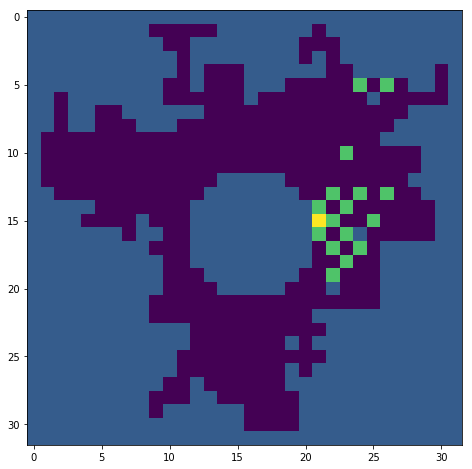

In [621]:
%%time
field, units = parse_input(file_input)
i, units = combat(field, units, plot=True)

In [624]:
i

79

In [625]:
(i) * sum([u.hp for u in units])

207770

In [626]:
field, units = parse_input(file_input)

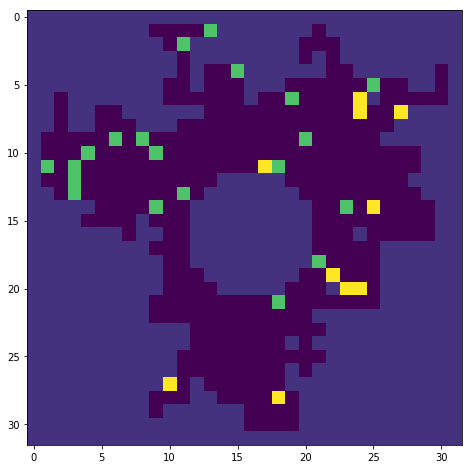

In [627]:
field[field==1] = 10
field[field==71] = 50
plt.imshow((field).T)

In [602]:
(i) * sum([u.hp for u in units]), (i-1) * sum([u.hp for u in units]) 

(207770, 205140)

In [603]:
print(file_input)

################################
#########....G#######.##########
##########.G########...#########
###########.########.#.#########
###########.#..G######..######.#
##########..#...###......G..##.#
##.#######......#..G....E#.....#
##.##..######...........E..E####
##.##...###................#####
#.....G.G...........G.....######
#...G....G...................###
#G.G.............EG..........###
#..G..........#####.........####
##.G.......G.#######.........###
#####....G..#########..G.E....##
####....#...#########.........##
#######.##..#########...#.....##
#########...#########.....######
##########..#########G....######
##########...#######..E...######
##########....#####...#EE.######
#########.........G.......######
#########............###########
############..........##########
############.......#.###########
###########...........##########
###########........#.###########
##########E.#......#############
#########...##....E.############
#########.######....############
##########

In [628]:
207770 - 3

207767